In [4]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
import ants

In [6]:
t2_path = r'../UTF-8IXI516-HH-2297-DE3Diso_-s3T223_-0401-00004-000002-02.nii'
t1_path = r'../UTF-8IXI516-HH-2297-MADisoTFE1_-s3T223_-0301-00003-000001-01.nii'

img_t2 = ants.image_read(t2_path)
img_t1 = ants.image_read(t1_path)

t2_img = nib.load(t2_path)
t1_img = nib.load(t1_path)

t2_data = t2_img.get_fdata()
t1_data = t1_img.get_fdata()

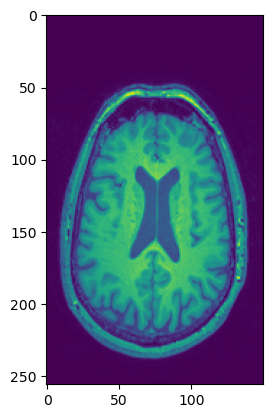

In [7]:
plt.imshow(img_t1[:,156,:].numpy())

In [8]:
#Code to obtain the corresponding slices since the slicing indexes arnt the same

t2_slice_idx = 70
t2_aff = t2_img.affine
t1_aff = t1_img.affine


t2_voxel = np.array([t2_data.shape[0]//2, t2_data.shape[1]//2, t2_slice_idx, 1])
t2_world = t2_aff @ t2_voxel  # Gives (x, y, z, 1)
t2_z_mm = t2_world[2]


t1_voxel = np.linalg.inv(t1_aff) @ t2_world
t1_slice_idx = int(round(t1_voxel[1])) 

print("Matching T1 slice index:", t1_slice_idx)

Matching T1 slice index: 151


In [9]:
def ants_rot90(antsimage, rot):
    # Extract the array representation
    image_array = antsimage.numpy()
    
    new_array = np.rot90(image_array, rot)
    
    # Create a new ANTs image from the manipulated array with the original metadata
    newantsimage = ants.from_numpy(new_array, origin=antsimage.origin, 
                                spacing=antsimage.spacing, direction=antsimage.direction)
    return newantsimage

In [22]:
fixed_image = img_t2[:,:,t2_slice_idx]
image_to_register = img_t1[:,t1_slice_idx,:]

# Rotate by -90 degrees to give the registration a good place to start
image_to_register = ants_rot90(image_to_register, -1)

# registration
result1 = ants.affine_initializer(fixed_image, image_to_register)
image_to_register = ants.apply_transforms( fixed=fixed_image, moving=image_to_register,
                                           transformlist=result1)

result2 = ants.registration(fixed_image, image_to_register, type_of_transform = 'Rigid' )
image_to_register = ants.apply_transforms( fixed=fixed_image, moving=image_to_register,
                                           transformlist=result2['fwdtransforms'])

result3 = ants.registration(fixed_image, image_to_register, type_of_transform = 'Affine' )
image_to_register = ants.apply_transforms( fixed=fixed_image, moving=image_to_register,
                                           transformlist=result3['fwdtransforms'])

result4 = ants.registration(fixed_image, image_to_register, type_of_transform = 'Affine' ) # SyNCC
image_to_register = ants.apply_transforms( fixed=fixed_image, moving=image_to_register,
                                           transformlist=result4['fwdtransforms'])
image4copy = image_to_register

result5 = ants.registration(fixed_image, image_to_register, type_of_transform = 'SyN' ) # SyNCC
image_to_register = ants.apply_transforms( fixed=fixed_image, moving=image_to_register,
                                           transformlist=result5['fwdtransforms'])

mywarpedimage = image_to_register

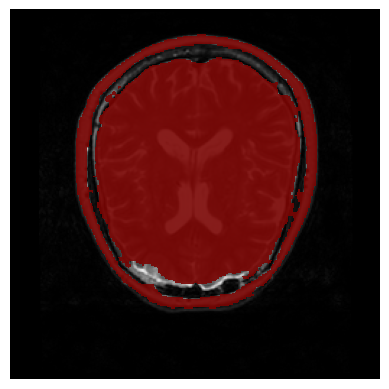

In [23]:
# plotting
ants.plot(fixed_image, overlay = mywarpedimage > mywarpedimage.mean())#, filename="overlay3.png")

(-0.5, 255.5, 255.5, -0.5)

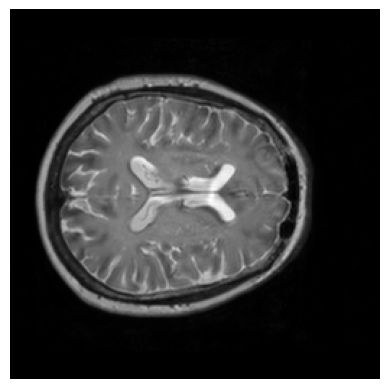

In [24]:
# plotting
myoverlay = (mywarpedimage.numpy() / 2) + (fixed_image.numpy() / 2)
plt.imshow(myoverlay, cmap='grey')
plt.axis("off")
#plt.savefig("overlay4.png")
#ants.plot(fixed_image, overlay = image4copy > mywarpedimage.mean())#, filename="overlay3.png")

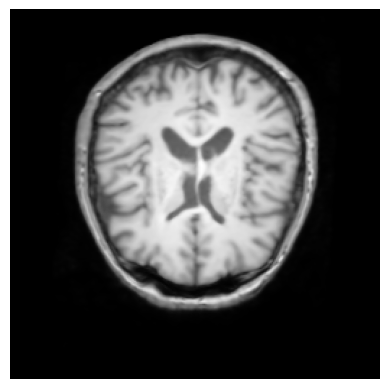

In [25]:
ants.plot(mywarpedimage)#, filename="warped3.png")

In [28]:
myaffineoverlay = (image4copy.numpy() / 2) + (fixed_image.numpy() / 2)
myoverlay = (mywarpedimage.numpy() / 2) + (fixed_image.numpy() / 2)

np.save("../affine5.npy", image4copy.numpy())
np.save("../warped5.npy", mywarpedimage.numpy())

np.save("../overlay5affine.npy", myaffineoverlay)
np.save("../overlay5.npy", myoverlay)

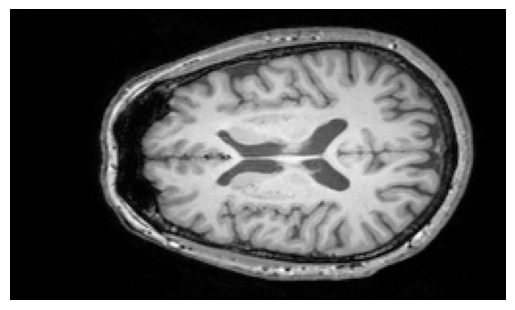

In [74]:
pre_transform = img_t1[:,t1_slice_idx,:]
ants.plot(pre_transform)

In [11]:
plt.imshow(t1_slice.numpy())

/usr/local/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/usr/local/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 't1_slice' is not defined

In [27]:
t2_slice = img_t2[:,:, t2_slice_idx]

t1_slice = img_t1[:, t1_slice_idx, :]

t1_slice = np.rot90(t1_slice)
t1_slice = np.fliplr(t1_slice)

ValueError: Axes=(0, 1) out of range for array of ndim=0.

In [30]:
t2_slice.shape

(256, 256)

In [12]:
t2_path = r'./UTF-8IXI516-HH-2297-DE3Diso_-s3T223_-0401-00004-000002-02.nii'
t1_path = r'./UTF-8IXI516-HH-2297-MADisoTFE1_-s3T223_-0301-00003-000001-01.nii'


t2_img = nib.load(t2_path)
t1_img = nib.load(t1_path)


t2_data = t2_img.get_fdata()
t1_data = t1_img.get_fdata()


print("T2 shape:", t2_data.shape)
print("T1 shape:", t1_data.shape)

T2 shape: (256, 256, 130)
T1 shape: (256, 256, 150)


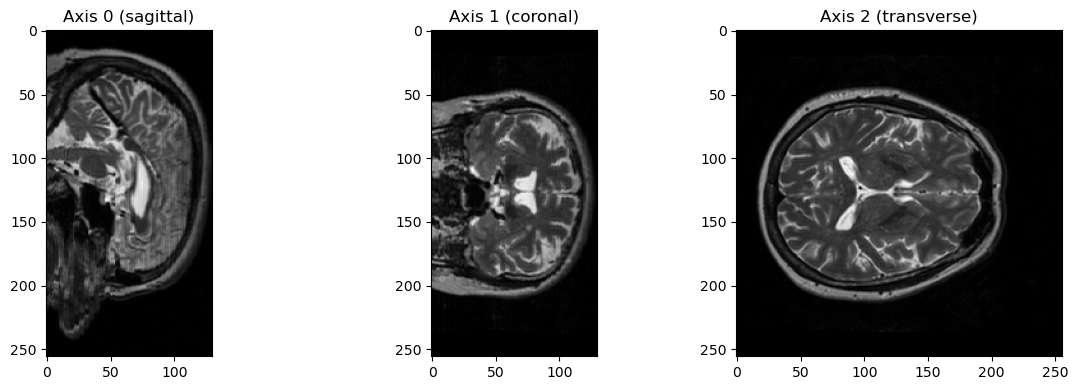

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(t2_data[t2_data.shape[0] // 2, :, :], cmap='gray')
axs[0].set_title('Axis 0 (sagittal)')

axs[1].imshow(t2_data[:, t2_data.shape[1] // 2, :], cmap='gray')
axs[1].set_title('Axis 1 (coronal)')

axs[2].imshow(t2_data[:, :, t2_data.shape[2] // 2], cmap='gray')
axs[2].set_title('Axis 2 (transverse)')

plt.tight_layout()
plt.show()

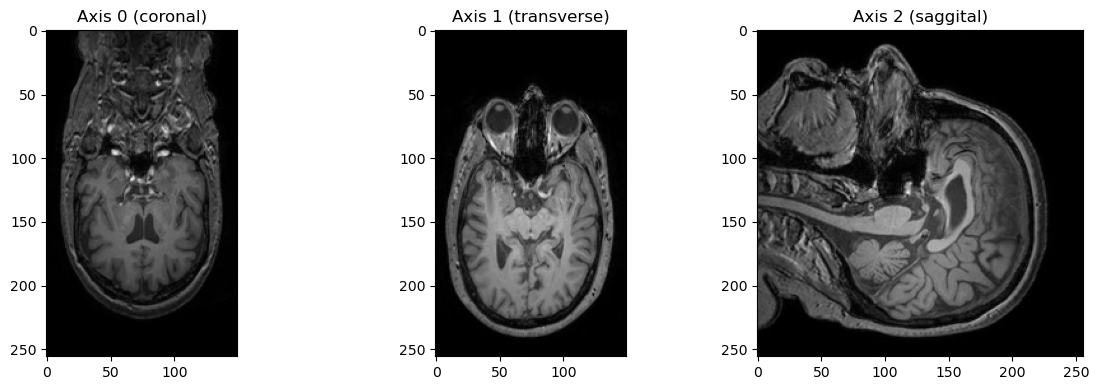

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(t1_data[t1_data.shape[0] // 2, :, :], cmap='gray')
axs[0].set_title('Axis 0 (coronal)')

axs[1].imshow(t1_data[:, t1_data.shape[1] // 2, :], cmap='gray')
axs[1].set_title('Axis 1 (transverse)')

axs[2].imshow(t1_data[:, :, t1_data.shape[2] // 2], cmap='gray')
axs[2].set_title('Axis 2 (saggital)')

plt.tight_layout()
plt.show()

In [16]:
t2_img.affine

array([[-9.33454633e-01,  3.58203016e-02,  1.05709337e-01,
         1.13879356e+02],
       [ 2.80970745e-02,  9.32690144e-01, -1.20782308e-01,
        -1.04771683e+02],
       [ 8.23364034e-02,  8.78197402e-02,  1.23965204e+00,
        -9.20539932e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [17]:
t2_slice = t2_data[:,:, t2_slice_idx]

t1_slice = t1_data[:, t1_slice_idx, :]

t1_slice = np.rot90(t1_slice)
t1_slice = np.fliplr(t1_slice)

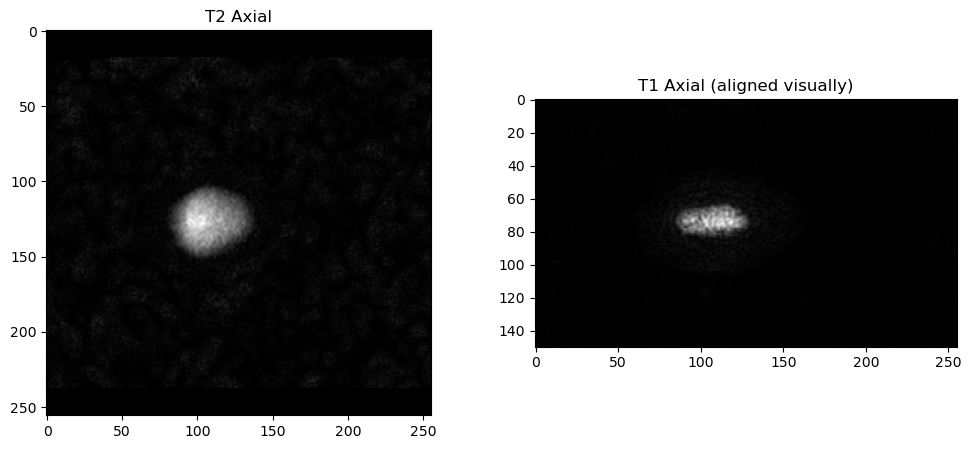

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(t2_slice, cmap='gray')
plt.title('T2 Axial')

plt.subplot(1, 2, 2)
plt.imshow(t1_slice, cmap='gray')
plt.title('T1 Axial (aligned visually)')
plt.show()

In [55]:
print("T2 slice shape:", t2_slice.shape)
print("T1 slice shape:", t1_slice.shape)

T2 slice shape: (256, 256)
T1 slice shape: (150, 256)
